# Simulation und lineare Regelung eines inversen Pendels mit Python

*2017, Christoph Hinze, ISW Uni Stuttgart*

Code-Beispiel zum Thema Skriptsparachen des Seminars "Entwickeln wissenschaftlicher Software". 

Modelliert wird ein inverses Pendel auf einem Wagen, dessen Beschleunigung als Stellgröße dient. Gemessen wird der Winkel $\theta$.

### Abhängigkeiten zum Ausführen dieses Dokuments: 

- [Python 3.x](https://www.python.org/downloads/)
- [Anaconda](https://docs.continuum.io/anaconda/) für numpy, scipy, matplotlib, pandas, jupyter-notebook, sympy
- [control](https://pypi.python.org/pypi/control/0.7.0)


## Inhalt

- Herleitung der symbolischen Modellgleichungen mit `sympy`
- Erzeugen der numerischen Gleichungen aus den symbolischen
- Simulation des Systems
- Linearisierung des Modells
- Lineare Regelung des Modells

## Importieren von benötigten Paketen
    
- Funktionalität ist in Pakete gekapselt
- Pakete können unter Alias-Namen importiert werden, um einfacher aufgerufen zu werden

In [51]:
import numpy as np
import control as ctrl 
import sympy as sym
import pandas

%matplotlib inline
import matplotlib
import matplotlib.animation
from sympy.utilities.lambdify import lambdify, lambdastr
from scipy.integrate import odeint

sym.init_printing()

## Laden von Daten von GitLab und einfache Plots

- Einfacher Import von Daten aus dem Internet mit `pandas` möglich
- Plotten der Daten aus `pandas` $\rightarrow$ interner Aufruf von `matplotlib`

pos     pos_d     angle   angle_d
0.000000  0.000000  0.000000  0.200000  0.000000
0.050251 -0.168663 -5.647750  0.117737 -2.757539
0.100503 -0.482913 -6.277048 -0.035775 -3.065413
0.150754 -0.762987 -4.661616 -0.172485 -2.276943
0.201005 -0.938461 -2.246468 -0.258785 -1.126269

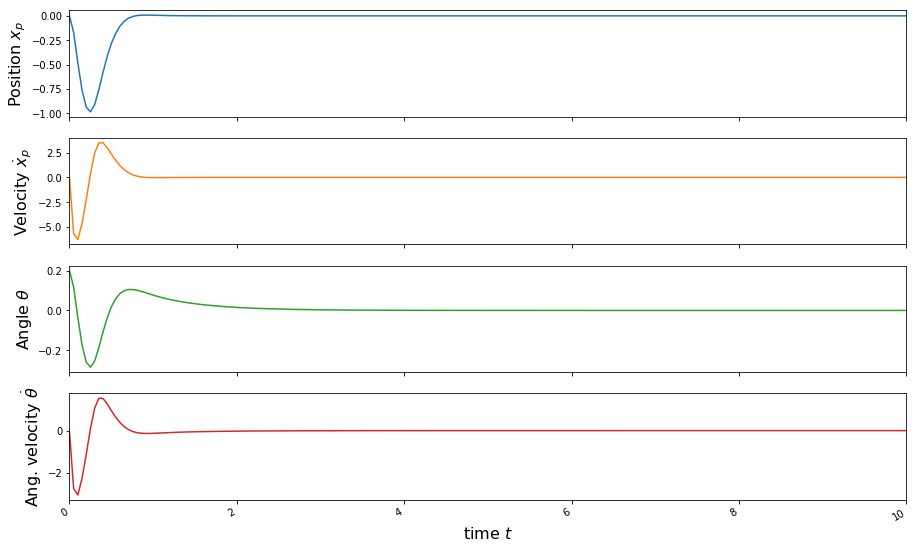

In [52]:
url = 'https://gitlab.com/ch.hinze/InversesPendel/raw/master/controlledPendulum.csv'
df = pandas.read_csv(url,index_col=0,parse_dates=[0],  sep='\t')
df=df.astype(float)



ax = df.plot(subplots=True, sharex=True, figsize = [15, 10], legend=False)

ax[3].set_xlabel("time $t$", fontsize=16)

ax[0].set_ylabel(r"Position $x_p$", fontsize=16)
ax[1].set_ylabel(r"Velocity $\dot x_p$", fontsize=16)
ax[2].set_ylabel(r"Angle $\theta$", fontsize=16)
ax[3].set_ylabel(r"Ang. velocity $\dot \theta$", fontsize=16)

df.head(5)

> Wie lassen sich dynamische Systeme mit Python simulieren?

## Modellbildung

### Beschreibung des Pendelmodells:

<img src="https://upload.wikimedia.org/wikipedia/commons/0/00/Cart-pendulum.svg" alt="Pendelmodell" style="width: 300px;"/>
*Quelle: wikimedia.org, Author: Krishnavedala *

### Symbolische Variablen anlegen

|Variable   | Beschreibung     |
|-----------|------------------|
| `p`       | Wagenposition |
| `p_dd`    |  Wagenbeschleunigung $\ddot p$ |
| `u`       |  Regelgröße $\equiv \ddot p$  |
| `theta`   |  Winkel des Pendels $\theta$ |
| `theta_dd`|  Winkelbeschleunigung des Pendels $\ddot \theta$ |
| `l`       |  Pendellänge $l$ |
| `mp`      |  Pendelmasse $m_p$ |
| `t`       |  Zeitvariable |
| `g`       |  Erdbeschleunigung $[m/s^2]$ |


In [3]:
p, p_d, p_dd, theta, theta_d, theta_dd, u = sym.symbols('p, p_d, p_dd, theta, theta_d, theta_dd, u')
l, mp = sym.symbols('l, mp')
t, g = sym.symbols('t, g')

### Zustandsgröße definieren

- Ebenfalls als symbolische Variable
- Implizite Abhängigkeit von der Zeit $t$
- Direktes Ableiten nach der Zeit möglich

In [4]:
x = sym.Matrix([theta(t)])
x_d = sym.diff(x, t)

x, x_d

###  Ortsvektor und Geschwindigkeit aufstellen

Lage:                     $\vec r = \begin{bmatrix}r_x(t) \\ r_y(t) \end{bmatrix} = \begin{bmatrix}p(t) - l\,\sin( \theta(t) ) \\ r_y(t) = l\,\cos(\theta(t))\end{bmatrix}$

Geschwindigkeit:          $ \vec v = \frac{\partial{ \vec r}}{\partial x} \dot x + \dot{ \vec r} $

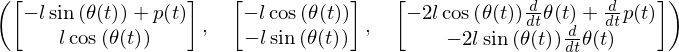

In [5]:
r = sym.Matrix([[p(t) - l*sym.sin(x[0])], [l*sym.cos(x[0])]])

v = r.jacobian(x)*x_d + sym.diff(r,t)

r, r.jacobian(x) , v

### Kinetische und Potenzielle Energie, Lagrange-Grundgleichung

$ T = \frac{1}{2} m \vec v^\mathrm{T} \vec v$

$ U = m g \Delta h $

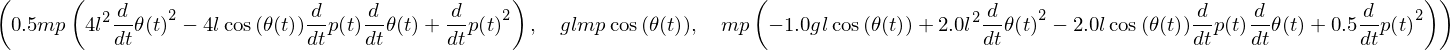

In [6]:
T = sym.simplify(sym.trigsimp( 0.5 * mp * (v[0]**2 + v[1]**2) ))

U = mp*g*l*sym.cos(x[0])

L = sym.simplify(sym.trigsimp(T - U ))

T, U, L

### Bewegungsgleichungen aus der Lagrange-Gleichung

$\frac{\mathrm d}{\mathrm d t}\frac{\partial L(x, \dot x)}{\partial \dot x} - \frac{\partial L(x, \dot x)}{\partial x} = \sum_i F_i$

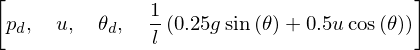

In [7]:
f_1 = [sym.diff(sym.diff(L,x_d_i),t)  for x_d_i in x_d]
f_2 = [sym.diff(L, x_i) for x_i in x]

eqs_of_motion = f_1[0] - f_2[0]

symbols_replacments = { sym.diff(theta(t),t,2) : theta_dd, 
                       sym.diff(p(t),t,2) : u, sym.diff(p(t),t) : p_d,
                       sym.diff(theta(t),t) : theta_d,
                       theta(t): theta, p(t): p}

eqs_of_motion = eqs_of_motion.xreplace(symbols_replacments)
x_dd_eq = sym.solve(eqs_of_motion, theta_dd)
x_dd_eq = [p_d, u, theta_d, x_dd_eq[0]]

x_dd_eq

### Konvertieren in $\lambda$-Funktion

 - Konvertieren von symbolischer Funktion in numerische Funktion für die Simulation

In [8]:
array2mat = [{'ImmutableDenseMatrix': np.matrix}, 'numpy']

odefun = lambdify((p_d, u, theta, theta_d, mp, l, g), x_dd_eq, modules=array2mat)
lambdastr((p_d, u, theta, theta_d, mp, l, g), x_dd_eq)#, modules=array2mat)



'lambda p_d,u,theta,theta_d,mp,l,g: ([p_d, u, theta_d, 0.25*(g*sin(theta) + 2.0*u*cos(theta))/l])'

### Simulationsmodell für freischwingendes Pendel

- Spezifizieren der Parameter
- Definition der Startbedingungen
- Definition der zu integrierenden Differenzialgleichung $\dot{\vec x} = \vec f(\vec x, t)$

In [64]:
class PendulumOnCart:
    """Pendel auf Wagen, ohne Bewegung im Wagen."""
    g = 9.81 # ms^(-2)
    m_p = 1 # kg
    l = 1 # m
    
    def __init__(self, functionHandle, x_0):
        self.f = functionHandle
        self.x_0 = x_0
        
    def odefun(self, x, t):
        u = 0
        return self.f(x[1], u, x[2], x[3], self.m_p,self.l, self.g)

 - Initialisieren eines Pendels

In [65]:
x_0 = [0, 0, np.pi-0.2, 0]
pendulum_model = PendulumOnCart(odefun, x_0)

### Simulation: Integration der Zustandsgleichungen

- Erstellen eines Zeitvektors
- Integieren der Differenzialgleichungen

In [11]:

t = np.linspace(0,10,200)
dt = t[1]-t[0]

y = odeint(pendulum_model.odefun, pendulum_model.x_0, t)

### Klasse zur Animation der Simulation

orientiert an https://matplotlib.org/2.0.0/examples/animation/double_pendulum_animated.html

In [63]:
from IPython.display import HTML

class PlotPendulum:
    def __init__(self, y, pendulum_model, t):
        self.t = t
        self.y = np.matrix(y).transpose()
        
        self.pos = self.y.getA()[0]
        y  = self.y.getA()[2]
        self.x_p = self.pos - pendulum_model.l*np.sin(y) 
        self.y_p = pendulum_model.l*np.cos(y) 
        
    def animInit(self, line, time_text):
        line.set_data([], [])
        time_text.set_text('')
        return line, time_text
    
    def animate(self, line, time_text, time_template, i):
        thisx = [self.pos[i], self.x_p[i]]
        thisy = [0, self.y_p[i]]

        
        line.set_data(thisx, thisy)
        time_text.set_text(time_template % (i*dt))
        return line, time_text
    
    def plotAnimation(self):
        fig = matplotlib.pyplot.figure()
        ax = fig.add_subplot(111, autoscale_on=False)
        ax.grid()
        #matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')
        matplotlib.pyplot.axis('scaled')
        ax.axis([-2, 2, -2, 2])
        
        matplotlib.pyplot.xlabel('x')
        matplotlib.pyplot.ylabel('y')
        matplotlib.pyplot.title('Animation of the Pendulum')

        line, = ax.plot([], [], 'ro-', lw=2)
        time_template = 'time = %.1fs'
        time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

        ani = matplotlib.animation.FuncAnimation(fig, lambda x: self.animate(line, time_text, time_template, x), np.arange(1, len(y)),
                              interval=(t[1]-t[0])*1000, blit=True, init_func=lambda: self.animInit(line, time_text))
        return ani



### Animation des freischwingenden Pendels

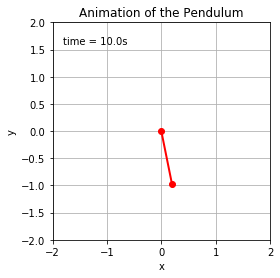

In [62]:
pplot = PlotPendulum(y, pendulum_model,t)
ani = pplot.plotAnimation()
HTML(ani.to_html5_video())
#pplot.x_p, pplot.y_p

### Simulation des Pendels mit $\cos$-Anregung

- Definition einer $cos(2t)$-Anregung als Stellgröße $u$

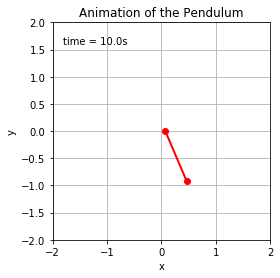

In [14]:
class SinePendulumOnCart:
    """Realizes the Pendulum on a Cart model for simulation and control."""
    g = 9.81 # ms^(-2)
    m_p = 1 # kg
    l = 1 # m
    
    def __init__(self, functionHandle, x_0):
        self.f = functionHandle
        self.x_0 = x_0
        
    def odefun(self, x, t):
        u = 0.5*(np.cos(2*t))
        #print(u)
        return self.f(x[1], u, x[2], x[3], self.m_p,self.l, self.g)


    x_0 = [0,0,0,0]
s_pend = SinePendulumOnCart(odefun, x_0)
s_y= odeint(s_pend.odefun, s_pend.x_0, t)

s_pplot = PlotPendulum(s_y, s_pend, t)
s_ani = s_pplot.plotAnimation()
HTML(s_ani.to_html5_video())


### Linearisierung

- Linearisierung der symbolischen Gleichungen über:
 $\vec A = \frac{\partial \vec f}{\partial \vec x} \big|_{\vec x = \vec x_s, u=u_s}$, $\vec b = \frac{\partial \vec f}{\partial \vec u} \big|_{\vec x = \vec x_s, u=u_s}$
- Die Messgröße ist $ \begin{bmatrix}0 & 0 & 1 & 0 \end{bmatrix}\vec x = \theta$

In [24]:
sys_eq = sym.Matrix(x_dd_eq)

sys_eq = sys_eq.subs({g: 9.81, mp: 1, l:1})

x_ = sym.Matrix([p, p_d, theta, theta_d])

A = sys_eq.jacobian(x_).subs({x_[0]: 0, x_[1]: 0, x_[2]: 0})

b = sys_eq.jacobian([u]).subs({x_[0]: 0, x_[1]: 0, x_[2]: 0})

#c = sym.Matrix([[1,0, 0,0], [0,0,1,0]])
c = sym.Matrix([0,0,1,0]).T

#d = sym.Matrix([0,0])
d =0

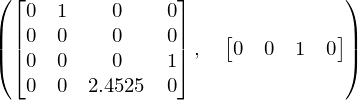

In [25]:
A, c

- Erzeugen eines linearen Systems mit dem  `control`-Modul.

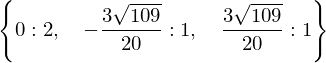

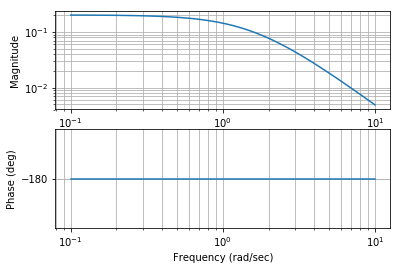

In [32]:
sys_lin = ctrl.ss(A, np.array(b).astype(np.float64),np.array(c).astype(np.float64),0)
ctrl.bode(sys_lin)
A.eigenvals()

### Plazierung der Pole des linearisierten Systems

- Pole auf Wunschkonfiguration legen über den `place`-Befehl (alle Eigenwerte negativ $\rightarrow$ stabiles System)
- **Reele Pole sind nicht möglich, da eine Kompensation nur über Schwingung funktioniert.**

In [35]:
A_ctrl = np.array(A).astype(np.float64)
b_ctrl = np.array(b).astype(np.float64)
K = ctrl.place(A_ctrl, b_ctrl, [-7, -7, -8, -10]) 
#K, S, E  = ctrl.lqr(sys_lin, np.diagflat([5, 10]), 1)

K

[sym.N(i) for i in list((A-b*K).eigenvals() )]#, (K*sym.Matrix(x_0[2:4]))[0]

/usr/local/lib/python3.5/dist-packages/slycot/synthesis.py:170: UserWarning: 1 violations of the numerical stability condition occured during the assignment of eigenvalues
  warnings.warn('%i violations of the numerical stability condition occured during the assignment of eigenvalues' % warn)


### Simulation des geregelten Systems

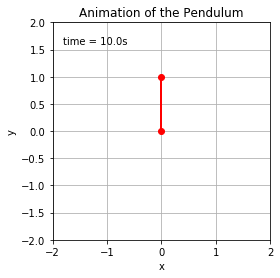

In [28]:
class LinearCtrlPendulumOnCart:
    """Realizes the Pendulum on a Cart model with a linear control."""
    g = 9.81 # ms^(-2)
    m_p = 1 # kg
    l = 1 # m
    
    def __init__(self, functionHandle, x_0, K):
        self.f = functionHandle
        self.x_0 = x_0
        
    def odefun(self, x, t):
        u = -(K*sym.Matrix(x))[0]
        return self.f(x[1], u, x[2], x[3], self.m_p,self.l, self.g)

x_0 = [0,0,0.2, 0]    

c_pend = LinearCtrlPendulumOnCart(odefun, x_0, K)
c_y = odeint(c_pend.odefun, c_pend.x_0, t)

c_pplot = PlotPendulum(c_y, c_pend, t)
c_ani = c_pplot.plotAnimation()
HTML(c_ani.to_html5_video())

### Export der Simulationsdaten in `.csv`-Datei

- Export der Daten mit `pandas`

In [ ]:
rowNames = ['pos','pos_d', 'angle', 'angle_d']
df = pandas.DataFrame([c_y[:,0], c_y[:,1], c_y[:,2], c_y[:,3]], index=rowNames, columns=t).T

fileName = 'controlledPendulum.csv'
df.to_csv(fileName, sep='\t', encoding='utf-8')

%matplotlib inline
ax = df.plot(subplots=True, sharex=True, figsize = [15, 10], legend=False)
ax[3].set_xlabel("time $t$", fontsize=16)
ax[0].set_ylabel(r"Position $x_p$", fontsize=16)
ax[1].set_ylabel(r"Velocity $\dot x_p$", fontsize=16)
ax[2].set_ylabel(r"Angle $\theta$", fontsize=16)
ax[3].set_ylabel(r"Ang. velocity $\dot \theta$", fontsize=16)